# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [393]:
from sklearn.base import BaseEstimator, RegressorMixin

In [410]:
class GradientBoosting(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=590, max_depth=2, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma = 1
        self.trees = []
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        first_tree = DecisionTreeRegressor(max_depth=self.max_depth).fit(x, y)
        self.trees.append(first_tree)
        y_new = y - self.trees[0].predict(x)
        for _ in range(self.n_estimators - 1):
            y_new -= self._fit_predict_tree(x, y_new)

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(x, y)
        self.trees.append(tree)
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = self.trees[0].predict(x)
        for tree in self.trees[1:]:
            y_pred += self.gamma * self.learning_rate * tree.predict(x)
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [395]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [396]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [397]:
from sklearn.model_selection import GridSearchCV

In [406]:
param_grid = {'n_estimators': range(500, 700, 10), 'max_depth': range(1, 5), "learning_rate": [0.05, 0.1, 0.3, 0.5, 0.7, 1]}

In [399]:
gscv = GridSearchCV(estimator=GradientBoosting(), scoring="neg_mean_squared_error", param_grid=param_grid, n_jobs=-1)

In [400]:
%%time
gscv.fit(X_train, y_train)

Wall time: 2min 10s


GridSearchCV(estimator=GradientBoosting(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.3, 0.5, 0.7, 1],
                         'max_depth': range(1, 5),
                         'n_estimators': range(500, 700, 20)},
             scoring='neg_mean_squared_error')

In [401]:
gscv.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 580}

In [413]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators=580, max_depth=3, learning_rate=0.05)
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

28.075227379943318

In [411]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators=590, max_depth=2)
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

16.18084438575686

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да / Нет

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [414]:
import pandas as pd

In [415]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [416]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [5]:
# pip install xgboost

In [6]:
# pip install catboost

In [417]:
# Референс

from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

C:\Users\Ivan\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7034692067348007

In [418]:
from catboost import CatBoostClassifier

In [422]:
X_train = pd.get_dummies(train.drop(['dep_delayed_15min'], axis=1), 
                         prefix=['Month', 'DayofMonth', 'DayofWeek', 'UniqueCarrier', 'Origin', 'Dest'], drop_first=True)
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [423]:
model = CatBoostClassifier()
model.fit(X_train_part, y_train_part)

Learning rate set to 0.063211
0:	learn: 0.6595473	total: 18.4ms	remaining: 18.3s
1:	learn: 0.6312473	total: 31.7ms	remaining: 15.8s
2:	learn: 0.6070634	total: 47.6ms	remaining: 15.8s
3:	learn: 0.5853740	total: 64.1ms	remaining: 16s
4:	learn: 0.5675079	total: 80.3ms	remaining: 16s
5:	learn: 0.5519802	total: 95.8ms	remaining: 15.9s
6:	learn: 0.5382668	total: 112ms	remaining: 15.9s
7:	learn: 0.5258546	total: 126ms	remaining: 15.7s
8:	learn: 0.5166724	total: 142ms	remaining: 15.7s
9:	learn: 0.5078393	total: 162ms	remaining: 16.1s
10:	learn: 0.5006851	total: 182ms	remaining: 16.4s
11:	learn: 0.4943405	total: 200ms	remaining: 16.5s
12:	learn: 0.4884208	total: 217ms	remaining: 16.5s
13:	learn: 0.4831446	total: 233ms	remaining: 16.4s
14:	learn: 0.4781113	total: 250ms	remaining: 16.4s
15:	learn: 0.4741868	total: 266ms	remaining: 16.4s
16:	learn: 0.4710183	total: 282ms	remaining: 16.3s
17:	learn: 0.4680400	total: 298ms	remaining: 16.2s
18:	learn: 0.4657450	total: 314ms	remaining: 16.2s
19:	learn

163:	learn: 0.4266303	total: 2.73s	remaining: 13.9s
164:	learn: 0.4265505	total: 2.75s	remaining: 13.9s
165:	learn: 0.4265037	total: 2.77s	remaining: 13.9s
166:	learn: 0.4264351	total: 2.79s	remaining: 13.9s
167:	learn: 0.4262888	total: 2.8s	remaining: 13.9s
168:	learn: 0.4262368	total: 2.82s	remaining: 13.9s
169:	learn: 0.4261622	total: 2.83s	remaining: 13.8s
170:	learn: 0.4260669	total: 2.85s	remaining: 13.8s
171:	learn: 0.4259497	total: 2.86s	remaining: 13.8s
172:	learn: 0.4258535	total: 2.88s	remaining: 13.8s
173:	learn: 0.4257405	total: 2.9s	remaining: 13.7s
174:	learn: 0.4256722	total: 2.92s	remaining: 13.7s
175:	learn: 0.4256150	total: 2.93s	remaining: 13.7s
176:	learn: 0.4255646	total: 2.95s	remaining: 13.7s
177:	learn: 0.4254737	total: 2.97s	remaining: 13.7s
178:	learn: 0.4253974	total: 2.99s	remaining: 13.7s
179:	learn: 0.4253322	total: 3s	remaining: 13.7s
180:	learn: 0.4252610	total: 3.02s	remaining: 13.7s
181:	learn: 0.4251476	total: 3.04s	remaining: 13.6s
182:	learn: 0.425

329:	learn: 0.4139379	total: 5.51s	remaining: 11.2s
330:	learn: 0.4138792	total: 5.53s	remaining: 11.2s
331:	learn: 0.4138068	total: 5.55s	remaining: 11.2s
332:	learn: 0.4137366	total: 5.56s	remaining: 11.1s
333:	learn: 0.4136758	total: 5.58s	remaining: 11.1s
334:	learn: 0.4135986	total: 5.59s	remaining: 11.1s
335:	learn: 0.4135200	total: 5.61s	remaining: 11.1s
336:	learn: 0.4134638	total: 5.63s	remaining: 11.1s
337:	learn: 0.4134025	total: 5.64s	remaining: 11.1s
338:	learn: 0.4133494	total: 5.66s	remaining: 11s
339:	learn: 0.4132916	total: 5.67s	remaining: 11s
340:	learn: 0.4132080	total: 5.69s	remaining: 11s
341:	learn: 0.4131288	total: 5.71s	remaining: 11s
342:	learn: 0.4130855	total: 5.73s	remaining: 11s
343:	learn: 0.4130115	total: 5.74s	remaining: 11s
344:	learn: 0.4129219	total: 5.76s	remaining: 10.9s
345:	learn: 0.4128473	total: 5.78s	remaining: 10.9s
346:	learn: 0.4127991	total: 5.79s	remaining: 10.9s
347:	learn: 0.4127445	total: 5.81s	remaining: 10.9s
348:	learn: 0.4126803	to

496:	learn: 0.4043977	total: 8.3s	remaining: 8.4s
497:	learn: 0.4043511	total: 8.32s	remaining: 8.39s
498:	learn: 0.4042949	total: 8.34s	remaining: 8.37s
499:	learn: 0.4042378	total: 8.35s	remaining: 8.35s
500:	learn: 0.4041799	total: 8.37s	remaining: 8.34s
501:	learn: 0.4041557	total: 8.39s	remaining: 8.32s
502:	learn: 0.4041208	total: 8.4s	remaining: 8.3s
503:	learn: 0.4040849	total: 8.42s	remaining: 8.28s
504:	learn: 0.4040473	total: 8.43s	remaining: 8.27s
505:	learn: 0.4039791	total: 8.45s	remaining: 8.25s
506:	learn: 0.4039448	total: 8.47s	remaining: 8.23s
507:	learn: 0.4038748	total: 8.48s	remaining: 8.22s
508:	learn: 0.4038489	total: 8.5s	remaining: 8.2s
509:	learn: 0.4037874	total: 8.52s	remaining: 8.19s
510:	learn: 0.4037250	total: 8.54s	remaining: 8.17s
511:	learn: 0.4037055	total: 8.55s	remaining: 8.15s
512:	learn: 0.4036477	total: 8.57s	remaining: 8.13s
513:	learn: 0.4035923	total: 8.59s	remaining: 8.12s
514:	learn: 0.4035470	total: 8.6s	remaining: 8.1s
515:	learn: 0.403503

659:	learn: 0.3967294	total: 11.1s	remaining: 5.7s
660:	learn: 0.3966932	total: 11.1s	remaining: 5.68s
661:	learn: 0.3966498	total: 11.1s	remaining: 5.67s
662:	learn: 0.3966085	total: 11.1s	remaining: 5.65s
663:	learn: 0.3965621	total: 11.1s	remaining: 5.63s
664:	learn: 0.3965120	total: 11.2s	remaining: 5.62s
665:	learn: 0.3964717	total: 11.2s	remaining: 5.6s
666:	learn: 0.3964137	total: 11.2s	remaining: 5.58s
667:	learn: 0.3963664	total: 11.2s	remaining: 5.57s
668:	learn: 0.3963116	total: 11.2s	remaining: 5.55s
669:	learn: 0.3962531	total: 11.2s	remaining: 5.53s
670:	learn: 0.3962283	total: 11.3s	remaining: 5.52s
671:	learn: 0.3961949	total: 11.3s	remaining: 5.5s
672:	learn: 0.3961326	total: 11.3s	remaining: 5.49s
673:	learn: 0.3960728	total: 11.3s	remaining: 5.47s
674:	learn: 0.3960236	total: 11.3s	remaining: 5.45s
675:	learn: 0.3959867	total: 11.3s	remaining: 5.44s
676:	learn: 0.3959295	total: 11.4s	remaining: 5.42s
677:	learn: 0.3958790	total: 11.4s	remaining: 5.4s
678:	learn: 0.39

820:	learn: 0.3902236	total: 13.9s	remaining: 3.02s
821:	learn: 0.3902083	total: 13.9s	remaining: 3s
822:	learn: 0.3901641	total: 13.9s	remaining: 2.99s
823:	learn: 0.3901324	total: 13.9s	remaining: 2.97s
824:	learn: 0.3900986	total: 13.9s	remaining: 2.95s
825:	learn: 0.3900588	total: 13.9s	remaining: 2.94s
826:	learn: 0.3899972	total: 14s	remaining: 2.92s
827:	learn: 0.3899525	total: 14s	remaining: 2.9s
828:	learn: 0.3899179	total: 14s	remaining: 2.89s
829:	learn: 0.3898765	total: 14s	remaining: 2.87s
830:	learn: 0.3898401	total: 14s	remaining: 2.85s
831:	learn: 0.3898095	total: 14.1s	remaining: 2.84s
832:	learn: 0.3898023	total: 14.1s	remaining: 2.82s
833:	learn: 0.3897500	total: 14.1s	remaining: 2.8s
834:	learn: 0.3897296	total: 14.1s	remaining: 2.79s
835:	learn: 0.3896788	total: 14.1s	remaining: 2.77s
836:	learn: 0.3896536	total: 14.1s	remaining: 2.75s
837:	learn: 0.3896172	total: 14.2s	remaining: 2.73s
838:	learn: 0.3895656	total: 14.2s	remaining: 2.72s
839:	learn: 0.3895239	total

979:	learn: 0.3842791	total: 16.7s	remaining: 340ms
980:	learn: 0.3842229	total: 16.7s	remaining: 323ms
981:	learn: 0.3841815	total: 16.7s	remaining: 306ms
982:	learn: 0.3841487	total: 16.7s	remaining: 289ms
983:	learn: 0.3841351	total: 16.7s	remaining: 272ms
984:	learn: 0.3841135	total: 16.7s	remaining: 255ms
985:	learn: 0.3840918	total: 16.8s	remaining: 238ms
986:	learn: 0.3840567	total: 16.8s	remaining: 221ms
987:	learn: 0.3840187	total: 16.8s	remaining: 204ms
988:	learn: 0.3839887	total: 16.8s	remaining: 187ms
989:	learn: 0.3839434	total: 16.8s	remaining: 170ms
990:	learn: 0.3839101	total: 16.8s	remaining: 153ms
991:	learn: 0.3838721	total: 16.9s	remaining: 136ms
992:	learn: 0.3838434	total: 16.9s	remaining: 119ms
993:	learn: 0.3838294	total: 16.9s	remaining: 102ms
994:	learn: 0.3837953	total: 16.9s	remaining: 85ms
995:	learn: 0.3837785	total: 16.9s	remaining: 68ms
996:	learn: 0.3837518	total: 16.9s	remaining: 51ms
997:	learn: 0.3837484	total: 17s	remaining: 34ms
998:	learn: 0.3837

In [424]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7485266908223965

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [27]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [28]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.done = None
        self.labels = None
        self.type = None
        self.cluster = []
        self.count = 1
        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # your code here
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # your code here
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        # your code here
        self.type = np.zeros(X.shape[0])
        self.done = np.zeros(X.shape[0])
        self.labels = np.zeros(X.shape[0])
        distances = distance.squareform(self.dist(X, 'euclidean'))
        for i in range(X.shape[0]):
            if self.done[i] == 0:
                self.done[i] = 1
                neighbours = list(self.range_query(distances[i]))
                if len(neighbours) < self.min_samples:
                    self.type[i] = 2
                else:
                    self.cluster.append(i)
                    self.labels[i] = self.count
                    self.grow_cluster(neighbours, distances)
                    self.cluster.append(neighbours)
                    self.count += 1
                    
        return self.labels

    def grow_cluster(self, neighbours, distances):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here
        new_neighbours = []
        for i in neighbours:
            if self.done[i] == 0:
                self.done[i] = 1
                new_neighbours = self.range_query(distances[i])
                if len(new_neighbours) >= self.min_samples:
                    for j in new_neighbours:
                        if j not in neighbours:
                            neighbours.append(j)    
            if self.labels[i] == 0:
                self.cluster.append(i)
                self.labels[i] = self.count

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        return np.where(x < self.eps)[0]
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        return distance.pdist(a, b)

Проверим себя на простом примере:

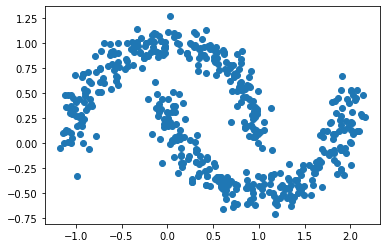

In [41]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

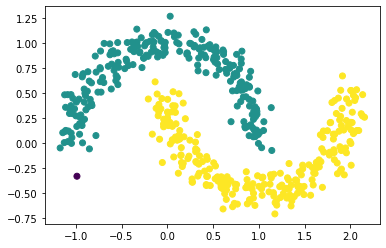

In [42]:
db = dbscan(0.2, 10)
clustered = db.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clustered)
plt.show()

Референс:

In [17]:
from sklearn.cluster import DBSCAN

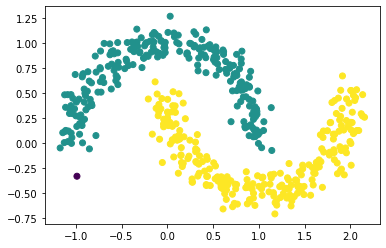

In [43]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

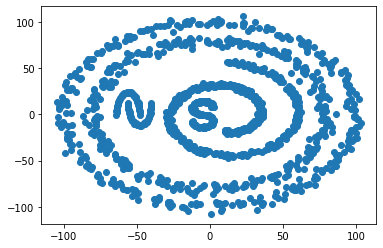

In [ ]:
# your code here

Или хотя бы что-нибудь такое: 

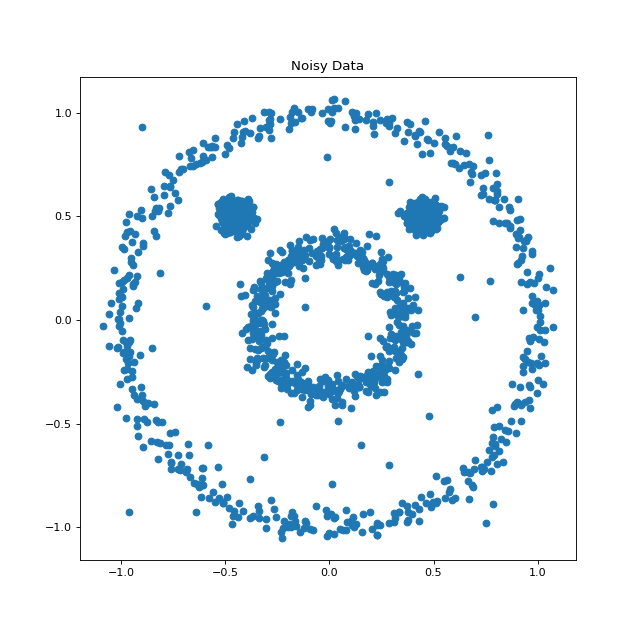

In [385]:
from sklearn import datasets

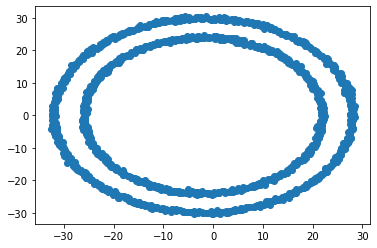

In [386]:
X2, _ = datasets.make_circles(n_samples=1500, noise=0.01)
X2 = X2 * 30
X2[:, 0] = X2[:, 0] - 2

plt.scatter(X2[:,0], X2[:,1])
plt.show()

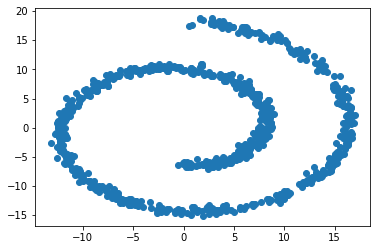

In [387]:
Y, _ = datasets.make_swiss_roll(n_samples=800, noise=0.3)
Y = np.delete(Y, 1, 1)
Y = Y * 1.3

plt.scatter(Y[:,0], Y[:,1])
plt.show()

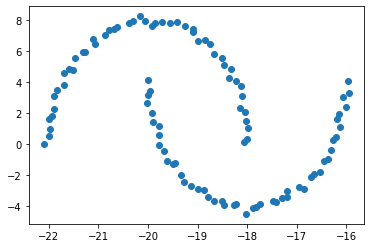

In [388]:
Z, _ = make_moons(n_samples=100, noise=0.02)
Z = Z * 4
Z[:,0] = Z[:,0] / 2 - 20
Z[:,1] = Z[:,1] * 2

plt.scatter(Z[:,0], Z[:,1])
plt.show()

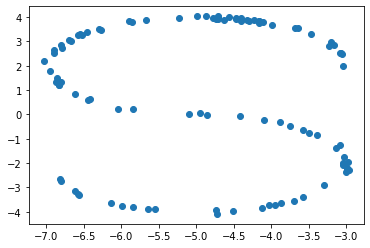

In [389]:
K, _ = datasets.make_s_curve(n_samples=100, noise=0.02)
K = np.delete(K, 1, 1)
K = K * 2
K[:,0] = K[:,0] - 5

plt.scatter(K[:,0], K[:,1])
plt.show()

In [390]:
V = np.vstack((X2, Y, Z, K))

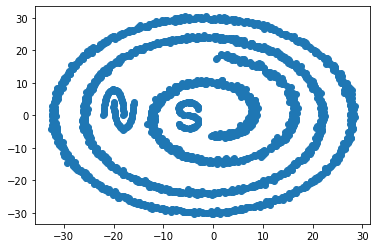

In [391]:
plt.scatter(V[:,0], V[:,1])
plt.show()

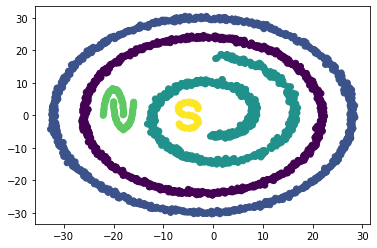

In [392]:
db = dbscan(3, 3)
clustered = db.fit_predict(V)
plt.scatter(V[:, 0], V[:, 1], c=clustered)
plt.show()

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [22]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 7.58 ms


In [20]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 82.3 ms
